In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import pickle
import itertools


In [3]:
data_dir = '../../../data/'

In [4]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [5]:
expdesign = scipy.io.loadmat(data_dir+'nsddata/experiments/nsd/nsd_expdesign.mat')
sharedix = expdesign['sharedix']

all_ids = []
shared_mask = []
shared_id_nums = []
max_session = np.zeros(len(subjid))
for sidx, sid in enumerate(subjid):
    
    data = pd.read_csv('../../../data/nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')
    
    max_session[sidx] = np.max(np.array(data['SESSION'])) 
    
    all_ids.append(np.array(data['73KID']))
    
    shared_mask.append(np.isin(all_ids[sidx],sharedix))
    shared_id_nums.append(np.array(data['73KID'])[shared_mask[sidx]])

In [6]:
shared_3_reps = []
for sidx, sid in enumerate(subjid):
    vals, idx_start, count = np.unique(shared_id_nums[sidx], return_counts=True,
                                    return_index=True)
    shared_3_reps.append(vals[count == n_repeats])
    
least_trials = min(shared_3_reps, key=len)


In [7]:
#okay let's find the shared id numbers again, but this time for the set of images 
#that was actually shown 3 times to each subject

shared_id_nums_3reps = []
shared_mask_3reps = []
for sidx, sid in enumerate(subjid):
    
    data = pd.read_csv('../../../data/nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')
    
    shared_mask_3reps.append(np.isin(all_ids[sidx],least_trials))
    
    shared_id_nums_3reps.append(np.array(data['73KID'])[shared_mask_3reps[sidx]])
    
#these id numbers are actually the same for each subject 
#(subjs were purposefully shown shared images at same trial nums)
#but b/c lengths are diff just kept it like this for ease

In [8]:
shared_betas_3reps = []
for sidx, sid in enumerate(subjid):
    
    print(sid)
    mask = shared_mask_3reps[sidx]
    
    for sess in range(1,int(max_session[sidx])+1):
        
        if(sess < 10):
            idx = '0' + str(sess)
        else:
            idx = str(sess)

        raw_betas = h5py.File(data_dir+'nsddata_betas/ppdata/subj'+ sid +'/nativesurface/betas_fithrf_GLMdenoise_RR/rh.betas_session'+idx+'.hdf5', 'r')
        betas = raw_betas['betas'][:]/300
        
        sess_shared_betas = betas[mask[(sess-1)*750:sess*750]]

        if(sess==1):
            subj_shared_betas = sess_shared_betas
        else:
            subj_shared_betas = np.concatenate((subj_shared_betas, sess_shared_betas))
    
    shared_betas_3reps.append(subj_shared_betas)

01
02


KeyboardInterrupt: 

In [5]:
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [13]:
rh_streams[0].shape

(226601,)

In [ ]:
sorted_shared_betas = []
for sidx, sid in enumerate(subjid):
    arr1inds = shared_id_nums_3reps[sidx].argsort()
    sorted_shared_betas.append(shared_betas_3reps[sidx][arr1inds[::-1]])

In [ ]:
del shared_betas_3reps #to help with memory probs

In [ ]:
betas_by_repeat = [[] for _ in range(len(subjid))]
for sidx, sid in enumerate(subjid):
    for r in range(n_repeats):
        betas_by_repeat[sidx].insert(r,sorted_shared_betas[sidx][r::3])

In [ ]:
# let's organize by ROI and get rid of vox outside of our ROIs to save space
betas_by_repeat_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
repeat_mean_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]

#two loops because otherwise we run out of mems
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        for r in range(n_repeats):       
            betas_by_repeat_by_ROI[sidx][roi_idx].insert(r,betas_by_repeat[sidx][r][:,rh_streams[sidx] == roi_idx+1])

del betas_by_repeat

In [ ]:
# save for future use
with open('rh_betas_by_repeat_by_ROI.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(betas_by_repeat_by_ROI, filehandle)

## RSMS

In [11]:
#Create RSMS

tril_flat_shape = int((betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,betas_by_repeat_by_ROI[0][0][0].shape[0],betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):

        for r in range(n_repeats):

            rsm[sidx,roi_idx,r,:,:] = np.corrcoef(betas_by_repeat_by_ROI[sidx][roi_idx][r])

            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel()

            flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0]


In [12]:
flat_rsm.shape

(8, 7, 132355, 3)

In [13]:
rsm_corr_within_subj_within_ROI = np.zeros((len(subjid),len(ROI_names)-1,3))

#within subj & ROI
for sidx, sid in enumerate(subjid):
    for roi_idx in range(len(ROI_names)-1):

        rsm_corr = [stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,1])[0],
                    stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,2])[0],
                    stats.pearsonr(flat_rsm[sidx,roi_idx,:,1],flat_rsm[sidx,roi_idx,:,2])[0]]

        rsm_corr_within_subj_within_ROI[sidx,roi_idx,:] = rsm_corr

In [14]:
mean_rsm_corr_within_subj_within_ROI = np.mean(rsm_corr_within_subj_within_ROI,axis=2) #mean across repeats

In [15]:
mean_rsm_corr_within_subj_within_ROI.shape

(8, 7)

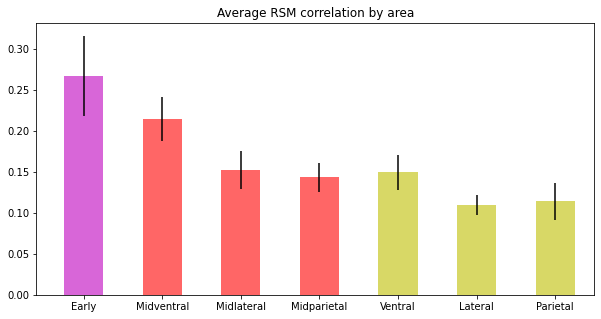

In [16]:
data = mean_rsm_corr_within_subj_within_ROI
error = stats.sem(mean_rsm_corr_within_subj_within_ROI, axis=0)

plt.figure(figsize=(10, 5))
xlocations = np.array(range(data.shape[1]))+.1
width = 0.5
plt.bar(xlocations, np.mean(mean_rsm_corr_within_subj_within_ROI, axis=0), 
        yerr=error, width=width, color = ['m','r','r','r','y','y','y'], alpha = .6)
plt.xticks(xlocations, ROI_names[1:])
plt.xlim(-0.5, xlocations[-1]+width)
plt.title("Average RSM correlation by area")
plt.gca().get_yaxis().tick_left()
plt.gca().get_xaxis().tick_bottom()

plt.savefig('../../../results/figures/rh_RSMcorr_withinROI_withinSubj_baseline.png')


In [21]:
roi_idx = np.arange(0,len(ROI_names)-1)
roi_combs = list(itertools.combinations(roi_idx, 2))

r1_trial_order = [0, 0, 1, 1, 2, 2]
r2_trial_order = [1, 2, 0, 2, 0, 1]

print(roi_combs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


In [22]:
rsm_corr_within_subj_between_ROI = np.zeros((len(subjid),len(list(roi_combs)),6))
rsm_corr_w_subj_b_ROI_same_trials = np.zeros((len(subjid),len(list(roi_combs)),3))


#within subj & between ROI
for sidx, sid in enumerate(subjid):
    
    c = 0
    for comb in roi_combs:
        
        roi_1 = comb[0]
        roi_2 = comb[1]
        
        for r in range(6):
            rsm_corr_within_subj_between_ROI[sidx,c,r] = stats.pearsonr(flat_rsm[sidx,roi_1,:,r1_trial_order[r]],
                                                                        flat_rsm[sidx,roi_2,:,r2_trial_order[r]])[0]
        
        for same in range(3):
            rsm_corr_w_subj_b_ROI_same_trials[sidx,c,same] = stats.pearsonr(flat_rsm[sidx,roi_1,:,same],
                                                                         flat_rsm[sidx,roi_2,:,same])[0]
        
        c += 1

In [23]:
test = np.mean(rsm_corr_within_subj_between_ROI,axis=2)
print(roi_combs[18])
print(test[:,18])
print(mean_rsm_corr_within_subj_within_ROI[:,4]) #ventral
print(mean_rsm_corr_within_subj_within_ROI[:,5]) #lateral


(4, 5)
[ 0.03214845  0.01525302  0.06835922 -0.0113583   0.04623685  0.02213708
  0.05435536  0.01878581]
[0.11445383 0.24573509 0.17043968 0.05457812 0.17201116 0.17404148
 0.09477215 0.16774191]
[0.11182992 0.10129672 0.14540142 0.10312666 0.16025701 0.12928657
 0.07218192 0.05313571]


In [24]:
np.where(np.array(roi_combs) == (4,5))

(array([ 4,  9, 13, 16, 18, 18, 19]), array([1, 1, 1, 1, 0, 1, 0]))

In [25]:
x = np.array(list(map(lambda x: x== (4,5), roi_combs)))
comb_idx = np.where(x)[0][0]

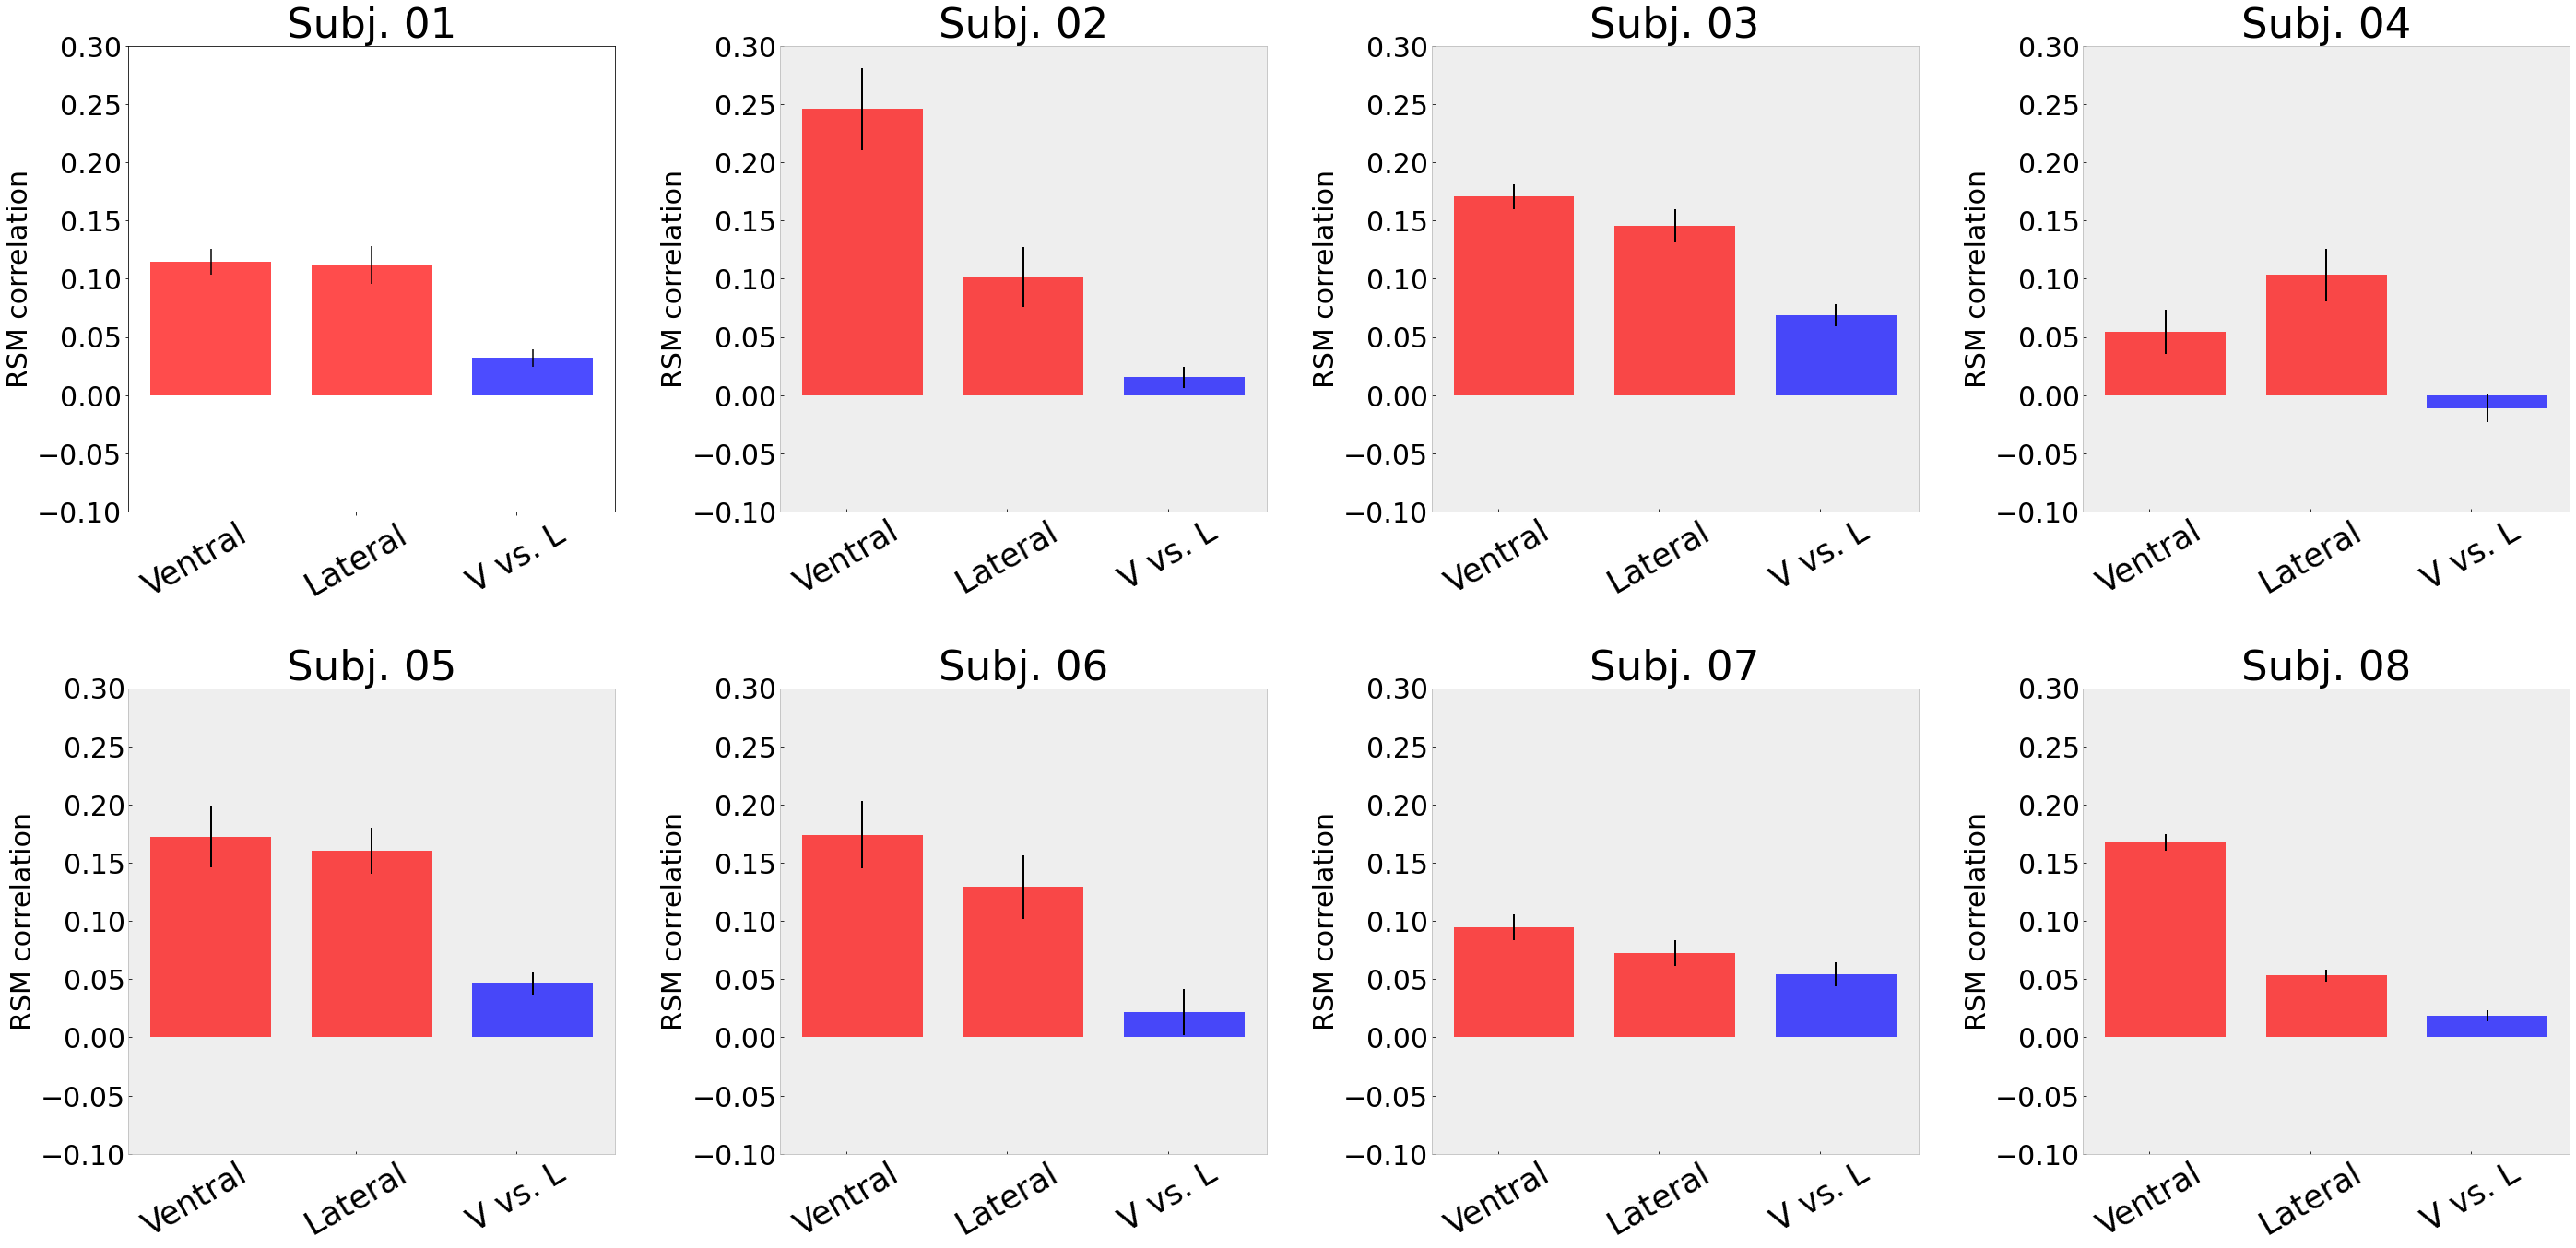

In [26]:
x = np.array(list(map(lambda x: x== (4,5), roi_combs)))
comb_idx = np.where(x)[0][0] #get idx for lateral vs ventral combination

plt.figure(figsize=(40, 20))

for sidx, sid in enumerate(subjid):

    plt.subplot(2, 4, sidx+1)
        
    data = [np.mean(rsm_corr_within_subj_within_ROI[sidx,4,:]), 
            np.mean(rsm_corr_within_subj_within_ROI[sidx,5,:]),
            np.mean(rsm_corr_within_subj_between_ROI[sidx,comb_idx,:])]
    
    error = [stats.sem(rsm_corr_within_subj_within_ROI[sidx,4,:]), 
             stats.sem(rsm_corr_within_subj_within_ROI[sidx,5,:]),
             stats.sem(rsm_corr_within_subj_between_ROI[sidx,comb_idx,:])]
    
    
    xlocations = np.array(range(3))+.1
    width = 0.75
    plt.bar(xlocations, data, yerr=error, width=width, alpha = 0.7, color = ['r', 'r', 'b'])
        
    #plt.hist(avg_corrvals[np.where(rh_streams == r)[0]],bins=50,alpha=0.7, rwidth=1, color = c[r])
    
    #plt.xlim(-0.1,1)
    #plt.xticks([fontsize=20])
    plt.xticks(np.arange(0, 3), ['Ventral', 'Lateral', 'V vs. L'], rotation=30, fontsize=35);
    
    plt.ylim(-0.1,0.3)
    plt.yticks(fontsize=30)
    
    plt.ylabel('RSM correlation',size = 30)
    
    title_string = "Subj. "
    title_string += sid
    plt.title(title_string,size = 45)
    
    plt.style.use("bmh")
    plt.grid(False)
    
    plt.tight_layout(pad=5)

plt.savefig('../../../results/figures/rh_RSMcorr_ventralVSlateral_baseline.png')


In [27]:
rsm_corr_within_subj_within_ROI[0,4,:].shape

(3,)

## Within subj RSM visualization

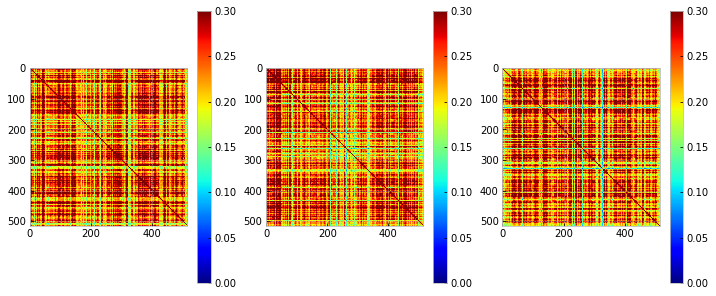

In [28]:
plt.figure(figsize=(12, 5))
for r in range(3):
    plt.subplot(1, 3, r+1)
    
    rsm_disp = rsm[1,4,r,:,:]

    plt.imshow(
        rsm_disp, 
        cmap='jet', 
    )
    plt.colorbar()
    plt.clim(0,.3)

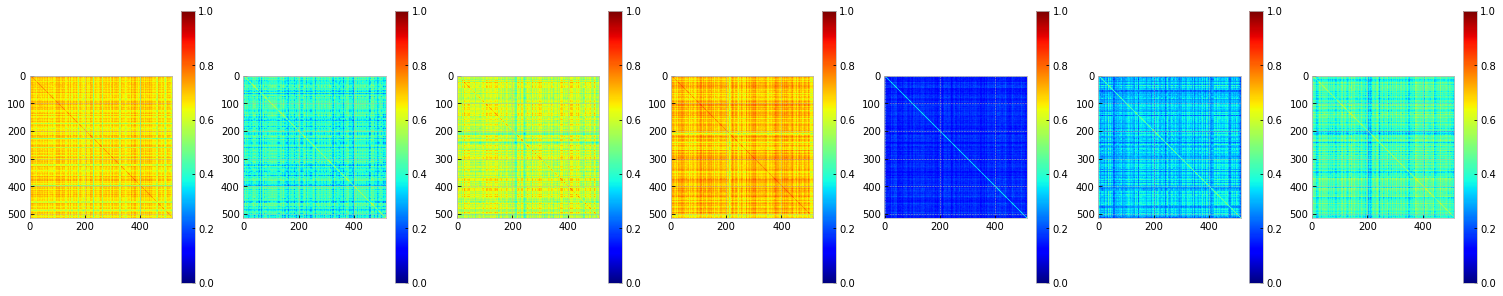

In [29]:
plt.figure(figsize=(30, 5))
for roi in range(len(ROI_names)-1):
    plt.subplot(1, 8, roi+1)
    
    rsm_disp = np.mean(rsm[0,roi,:,:,:],axis=0)

    plt.imshow(
        rsm_disp, 
        cmap='jet', 
    )
    plt.colorbar()
    plt.clim(0,1)

In [20]:
np.mean(rsm[1,roi,:,:,:]).shape

()

In [ ]:
betas_by_repeat_by_ROI